# Bibliotecas

Vamos usar a biblioteca de alto nível [Stable Baselines3](https://stable-baselines3.readthedocs.io/en/master/) que contém a implementação do Deep Q-learning (DQN), dentre outros algoritmos de aprendizado por reforço.

In [77]:
# Importa as bibliotecas principais
#import gymnasium as gymm       
#import gymnasium as gymm

import gymnasium as gymm
import sys

# Create a gym module alias that stable-baselines3 expects
sys.modules['gym'] = gymm
gymm.__version__ = getattr(gymm, '__version__', '0.29.1')


# Biblioteca de simulações de ambientes para RL
import imageio                        # Usada para salvar a sequência de frames como GIF
import os , shutil
from IPython.display import Image     # Para exibir a imagem (GIF) diretamente no notebook
import numpy as np                    # Importa o pacote NumPy, amplamente utilizado para manipulação de arrays e operações numéricas vetoriais
from typing import Dict, Tuple, List  # Importa ferramentas de tipagem estática do Python
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, ProgressBarCallback
from stable_baselines3.common.monitor import Monitor
from torchinfo import summary
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import torch
import pandas as pd
import seaborn as sns

# Ambientes

In [65]:
ambientes = ["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]
amb = ambientes[1]
train_env = Monitor(gymm.make(amb, render_mode=None))
eval_env  = Monitor(gymm.make(amb, render_mode=None))

# Callback

In [66]:
# Configura avaliação periódica
eval_cb = EvalCallback(
    eval_env,                 	  # ambiente só para avaliação
    eval_freq=1000,               # faz avaliação a cada 1 000 passos de treino
    n_eval_episodes=1,           # roda 10 episódios por avaliação
    log_path="./logs/" + amb,     # grava evaluations.npz nessa pasta
    deterministic=True,           # usa ações gulosas
    verbose=0                     # sem mensagens no console
)

# Hiperparâmetros

In [67]:
params = {
    "CartPole-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 2.3e-3,
        "batch_size": 64,
        "buffer_size": 100_000,
        "learning_starts": 1_000,
        "gamma": 0.99,
        "target_update_interval": 10,
        "train_freq": 256,
        "gradient_steps": 128,
        "exploration_fraction": 0.16,
        "exploration_final_eps": 0.04,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "MountainCar-v0": {
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "batch_size": 128,
        "buffer_size": 10_000,
        "learning_starts": 1_000,
        "gamma": 0.98,
        "target_update_interval": 600,
        "train_freq": 16,
        "gradient_steps": 8,
        "exploration_fraction": 0.20,
        "exploration_final_eps": 0.07,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "Acrobot-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 6.3e-4,
        "batch_size": 128,
        "buffer_size": 50_000,
        "learning_starts": 0,
        "gamma": 0.99,
        "target_update_interval": 250,
        "train_freq": 4,
        "gradient_steps": -1,
        "exploration_fraction": 0.12,
        "exploration_final_eps": 0.10,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
}
n_timesteps = {
    "CartPole-v1": 5e4,
    "MountainCar-v0": 1.2e5,
    "Acrobot-v1":1e5
}

[**Hiperparâmetros**](https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#):

`learning_rate`: taxa de aprendizado

`batch_size`: tamanho do mini lote.

`buffer_size`: capacidade máxima do replay buffer; ao atingir o limite, amostras mais antigas são sobrescritas.

`learning_starts`: número de interações com o ambiente antes de iniciar o treinamento.

`gamma`: fator de desconto.

`train_freq`: frequência (em passos de ambiente) com que a rede é atualizada; a cada train_freq interações executa-se um ciclo de treino.

`gradient_steps`: número de passos de otimização consecutivos executados.

`target_update_interval`: número de passos entre as atualizações dos pesos da rede-alvo.

`exploration_fraction`: fração do total de passos de treino para decaimento de epsilon.

`exploration_final_eps`: valor final de epsilon após o decaimento.

`policy_kwargs = dict(net_arch=[256, 256])`: argumentos adicionais passados à política; aqui define-se uma MLP com duas camadas totalmente conectadas de 256 unidades cada.

# Modelo

### DQN 

DQN é um algoritmo que combina Q-learning com redes neurais profundas para permitir que um agente aprenda a tomar decisões ótimas em ambientes complexos e de alta dimensão 

Pelo fundamento do Q-learning sendo do objetivo sendo aprender uma gunção de valor $Q(s,a)$, que estima a recompensa total futura ao tomar a ação a no estado S por uma tabela Q-table 

### Pilares fundamentais 

3. Pilar 1: Replay de Experiência (Experience Replay)

Para evitar instabilidade no treino, o DQN não aprende apenas com a última experiência.

- Como funciona: O agente armazena suas experiências $(s,a,r,s′)$ em uma memória. Durante o treino, amostras aleatórias (mini-lotes) são retiradas dessa memória para atualizar a rede.

- Por que é importante: Quebra a correlação entre amostras sequenciais, tornando o aprendizado mais estável e eficiente.

4. Pilar 2: Redes Alvo (Target Networks)

Treinar uma rede usando alvos que ela mesma gera cria um "alvo móvel", causando instabilidade.

- Como funciona: O DQN usa duas redes. A Rede Principal é treinada a todo momento, enquanto a Rede Alvo (uma cópia da principal) é usada para calcular o valor de referência e tem seus pesos atualizados com menos frequência.

Por que é importante: Mantém o alvo de treinamento estável por mais tempo, permitindo que a rede principal convirja de forma mais segura. A função de perda (loss) minimiza a diferença entre a previsão da rede principal e o alvo gerado pela rede alvo.

### Algoritmo 

O Algoritmo em Resumo

- Interaja: O agente executa uma ação no ambiente e armazena a transição (estado, ação, recompensa, próximo estado) na memória de replay.

- Amostre: Um lote aleatório de transições é retirado da memória.

- Calcule o Alvo: A Rede Alvo calcula o valor Q de referência para o próximo estado.

- Treine: A Rede Principal é treinada para minimizar a diferença entre sua previsão e o alvo calculado no passo anterior.

- Atualize: Periodicamente, os pesos da Rede Principal são copiados para a Rede Alvo.

In [68]:
params[amb].update({"env": train_env, "verbose": 0})
model = DQN(**params[amb])

In [69]:
summary(
    model.policy.q_net,
    input_size=(1,) + train_env.observation_space.shape,  # (batch_size, *observation_space.shape)
    col_names=["input_size", "output_size", "num_params"],
    depth=3
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
QNetwork                                 [1, 4]                    [1, 2]                    --
├─FlattenExtractor: 1-1                  [1, 4]                    [1, 4]                    --
│    └─Flatten: 2-1                      [1, 4]                    [1, 4]                    --
├─Sequential: 1-2                        [1, 4]                    [1, 2]                    --
│    └─Linear: 2-2                       [1, 4]                    [1, 256]                  1,280
│    └─ReLU: 2-3                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-4                       [1, 256]                  [1, 256]                  65,792
│    └─ReLU: 2-5                         [1, 256]                  [1, 256]                  --
│    └─Linear: 2-6                       [1, 256]                  [1, 2]                    514
Total params: 67,586
Traina

# Treinamento

In [70]:
model.learn(total_timesteps=n_timesteps[amb],
            callback=eval_cb,
            log_interval=None,
            progress_bar=False)
model.save("dqn")
model = DQN.load("dqn")

# Resultados

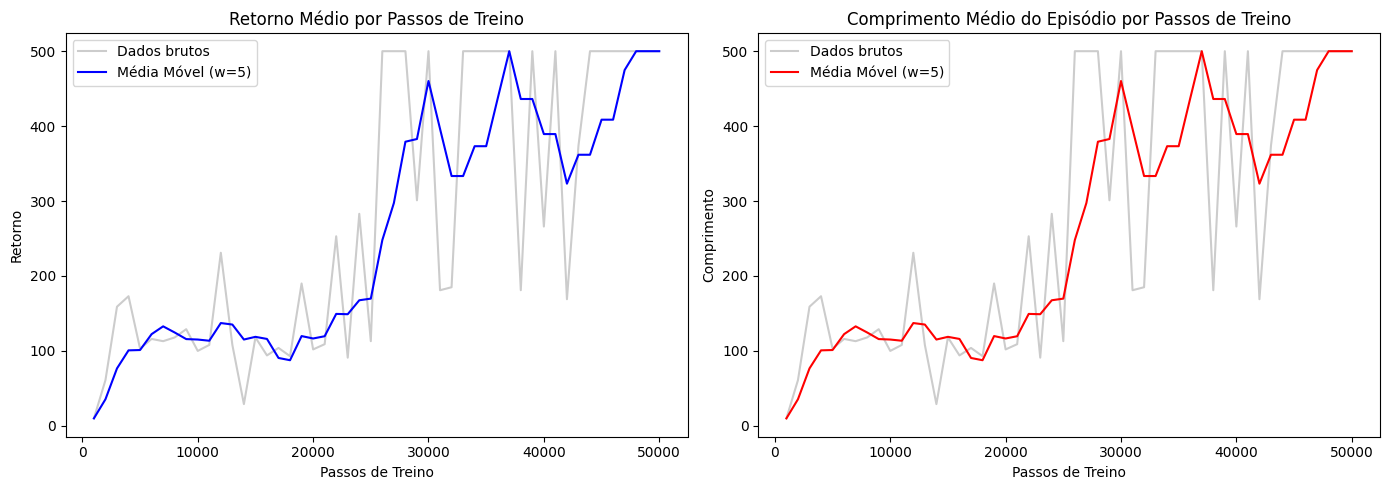

In [71]:
# 1. Carregar dados
data = np.load(f"logs/{amb}/evaluations.npz") # caminho passado para o EvalCallback
timesteps   = data["timesteps"]     # shape (n_evals,)
returns_raw = data["results"]      # shape (n_evals, n_eval_episodes)
lengths_raw = data["ep_lengths"]   # shape (n_evals, n_eval_episodes)

# 2. Calcular médias por ponto de avaliação
mean_ret = returns_raw.mean(axis=1)
mean_len = lengths_raw.mean(axis=1)

# 3. Criar DataFrame e média móvel (janela=5)
df = pd.DataFrame({
    "Passos de Treino": timesteps,
    "Retorno Médio": mean_ret,
    "Comprimento Médio": mean_len
})
df["Retorno MM"]     = df["Retorno Médio"].rolling(window=5, min_periods=1).mean()
df["Comprimento MM"] = df["Comprimento Médio"].rolling(window=5, min_periods=1).mean()

# 4. Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Retorno médio
sns.lineplot(
    x="Passos de Treino", y="Retorno Médio",
    data=df, ax=axes[0],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Retorno MM",
    data=df, ax=axes[0],
    label="Média Móvel (w=5)",
    color="blue"
)
axes[0].set(
    title="Retorno Médio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Retorno"
)
axes[0].legend()

# Comprimento médio do episódio
sns.lineplot(
    x="Passos de Treino", y="Comprimento Médio",
    data=df, ax=axes[1],
    label="Dados brutos",
    color="gray", alpha=0.4
)
sns.lineplot(
    x="Passos de Treino", y="Comprimento MM",
    data=df, ax=axes[1],
    label="Média Móvel (w=5)",
    color="red"
)
axes[1].set(
    title="Comprimento Médio do Episódio por Passos de Treino",
    xlabel="Passos de Treino",
    ylabel="Comprimento"
)
axes[1].legend()

plt.tight_layout()
plt.show()

In [72]:
# Carrega o modelo e recria o ambiente
#["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]

if amb == "MountainCar-v0":
  env    = gymm.make(amb)

  model = DQN.load("dqn", env=env, print_system_info=False)

  device = torch.device("cpu")
  # helper: SB3 policy → torch tensor → numpy Q-values
  def q_values(obs: np.ndarray) -> np.ndarray:
      with torch.no_grad():
          obs_t = torch.as_tensor(obs, dtype=torch.float32 , device=model.device)
          q = model.policy.q_net(obs_t).cpu().numpy()
      return q

  # Constrói a grade de estados (posição, velocidade)
  pos_min, pos_max = env.observation_space.low[0],  env.observation_space.high[0]
  vel_min, vel_max = env.observation_space.low[1],  env.observation_space.high[1]

  N = 100                              # resolução da malha
  pos = np.linspace(pos_min, pos_max, N)
  vel = np.linspace(vel_min, vel_max, N)
  P, V = np.meshgrid(pos, vel)        # cada um (N,N)

  grid_states = np.stack([P.ravel(), V.ravel()], axis=1)   # (N², 2)

  # Avalia a rede (cost-to-go)
  qs          = q_values(grid_states)            # (N², 3 ações)
  values      = np.max(qs, axis=1)               # V(s) = max_a Q(s,a)
  cost_to_go  = - values.reshape(N, N)           # sinal trocado

  # Gráfico interativo
  surf = go.Surface(x=P, y=V, z=cost_to_go, colorscale="Viridis", showscale=False)
  fig_plotly = go.Figure(surf)
  fig_plotly.update_layout(
      title="Superfície cost-to-go (DQN) | Ambiente: " + amb,
      scene=dict(xaxis_title="Position",
                yaxis_title="Velocity",
                zaxis_title="Cost-to-go (–max Q)",
                aspectratio=dict(x=1, y=1, z=0.5)),
      margin=dict(l=0, r=0, b=0, t=30)
  )
  fig_plotly.show()

# Simulacão com a rede treinada

In [73]:
env = gymm.make(amb, render_mode="rgb_array")
frames   = []
episodes = 1              # how many episodes to record
max_steps = 500           # MountainCar episode length
for ep in range(episodes):
    observation, info = env.reset()
    for step in range(max_steps):
        # agent acts
        action, _states = model.predict(observation, deterministic=True)
        observation, reward, terminated, truncated, info = env.step(action)
        frames.append(env.render())
        if terminated or truncated:
            break
env.close()

In [74]:
# Salva os frames coletados como um arquivo GIF animado
gif_path = amb + ".gif"
imageio.mimsave(gif_path, frames, format="GIF", duration=40)

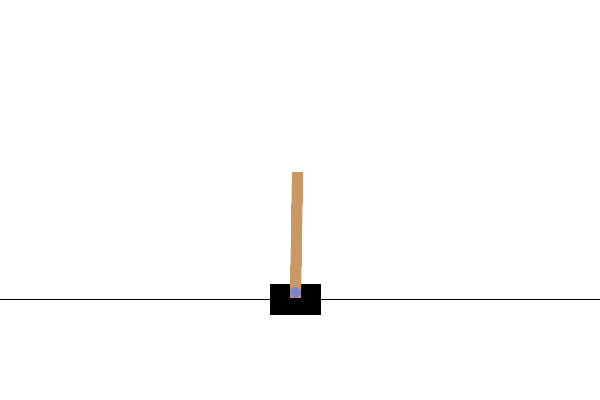

In [76]:
# Exibe o GIF diretamente no notebook
Image(filename=gif_path)

In [78]:
params = {
    "CartPole-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 2.3e-3,
        "batch_size": 64,
        "buffer_size": 100_000,
        "learning_starts": 1_000,
        "gamma": 0.99,
        "target_update_interval": 10,
        "train_freq": 256,
        "gradient_steps": 128,
        "exploration_fraction": 0.16,
        "exploration_final_eps": 0.04,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "MountainCar-v0": {
        "policy": "MlpPolicy",
        "learning_rate": 4e-3,
        "batch_size": 128,
        "buffer_size": 10_000,
        "learning_starts": 1_000,
        "gamma": 0.98,
        "target_update_interval": 600,
        "train_freq": 16,
        "gradient_steps": 8,
        "exploration_fraction": 0.20,
        "exploration_final_eps": 0.07,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
    "Acrobot-v1": {
        "policy": "MlpPolicy",
        "learning_rate": 6.3e-4,
        "batch_size": 128,
        "buffer_size": 50_000,
        "learning_starts": 0,
        "gamma": 0.99,
        "target_update_interval": 250,
        "train_freq": 4,
        "gradient_steps": -1,
        "exploration_fraction": 0.12,
        "exploration_final_eps": 0.10,
        "policy_kwargs": {"net_arch": [256, 256]},
    },
}
n_timesteps = {
    "CartPole-v1": 5e4,
    "MountainCar-v0": 1.2e5,
    "Acrobot-v1":1e5
}

def run_sensitivity_analysis(env_name, param_name, param_values):
    """
    Executa uma análise de sensibilidade para um hiperparâmetro específico de um agente DQN.

    :param env_name: (str) Nome do ambiente do Gymnasium.
    :param param_name: (str) Nome do hiperparâmetro a ser variado.
    :param param_values: (list) Lista de valores para o hiperparâmetro.
    """
    print(f"--- Iniciando análise de sensibilidade para '{param_name}' no ambiente '{env_name}' ---")

    # Limpa o diretório de logs para garantir que os resultados sejam novos
    if os.path.exists("./logs/"):
        shutil.rmtree("./logs/")

    all_results = []

    # Loop para treinar o modelo com cada valor do hiperparâmetro
    for value in tqdm(param_values, desc=f"Variando {param_name}"):
        # Copia os parâmetros padrão para não modificar o dicionário original
        current_params = params[env_name].copy()
        current_params[param_name] = value

        # Define um caminho de log único para cada execução
        log_path = f"./logs/{param_name}_{value}/"
        os.makedirs(log_path, exist_ok=True)

        # Configura os ambientes de treino e avaliação
        train_env = Monitor(gymm.make(env_name))
        eval_env = Monitor(gymm.make(env_name))

        # Configura o callback para avaliação periódica
        eval_callback = EvalCallback(
            eval_env,
            log_path=log_path,
            eval_freq=1000,
            n_eval_episodes=10, # Avalia em 10 episódios para ter uma média mais estável
            deterministic=True,
            render=False,
            verbose=0
        )

        # Cria e treina o modelo DQN
        model = DQN(env=train_env, **current_params, verbose=0)
        model.learn(total_timesteps=int(n_timesteps[env_name]), callback=eval_callback)

    # --- Processamento e Plotagem dos Resultados ---
    print("\n--- Processando resultados e gerando gráficos ---")
    
    combined_df = pd.DataFrame()

    # Carrega os resultados de cada execução
    for value in param_values:
        log_path = f"./logs/{param_name}_{value}/evaluations.npz"
        data = np.load(log_path)
        
        df = pd.DataFrame({
            "Passos de Treino": data["timesteps"],
            "Retorno Médio": data["results"].mean(axis=1),
            "Comprimento Médio": data["ep_lengths"].mean(axis=1)
        })
        df[param_name] = value
        combined_df = pd.concat([combined_df, df], ignore_index=True)

    # Calcula a média móvel para suavizar as curvas
    combined_df["Retorno MM"] = combined_df.groupby(param_name)["Retorno Médio"].transform(lambda x: x.rolling(5, 1).mean())
    combined_df["Comprimento MM"] = combined_df.groupby(param_name)["Comprimento Médio"].transform(lambda x: x.rolling(5, 1).mean())

    # Plotagem
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f'Análise de Sensibilidade do Hiperparâmetro: {param_name} no Ambiente: {env_name}', fontsize=16)

    # Gráfico de Retorno Médio
    sns.lineplot(data=combined_df, x="Passos de Treino", y="Retorno MM", hue=param_name, ax=axes[0], palette="viridis")
    axes[0].set_title("Retorno Médio por Passos de Treino")
    axes[0].set_xlabel("Passos de Treino")
    axes[0].set_ylabel("Retorno Médio (Média Móvel)")
    axes[0].legend(title=param_name)
    axes[0].grid(True)

    # Gráfico de Comprimento do Episódio
    sns.lineplot(data=combined_df, x="Passos de Treino", y="Comprimento MM", hue=param_name, ax=axes[1], palette="viridis", legend=False)
    axes[1].set_title("Comprimento Médio do Episódio por Passos de Treino")
    axes[1].set_xlabel("Passos de Treino")
    axes[1].set_ylabel("Comprimento Médio (Média Móvel)")
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"sensitivity_{param_name}_{env_name}.png")
    plt.show()


--- Iniciando análise de sensibilidade para 'learning_rate' no ambiente 'CartPole-v1' ---


Variando learning_rate: 100%|██████████| 4/4 [05:10<00:00, 77.54s/it]



--- Processando resultados e gerando gráficos ---


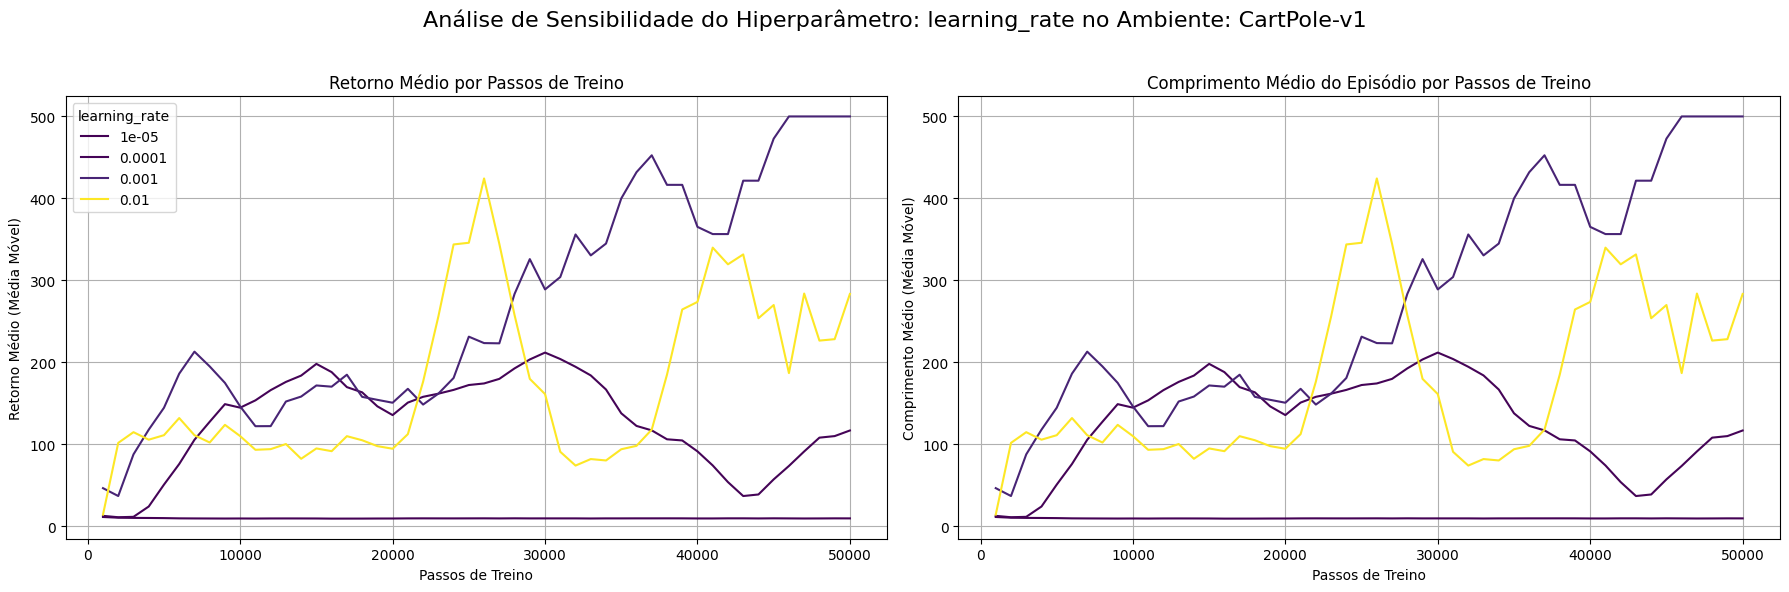

--- Iniciando análise de sensibilidade para 'gamma' no ambiente 'CartPole-v1' ---


Variando gamma: 100%|██████████| 4/4 [05:31<00:00, 82.83s/it]



--- Processando resultados e gerando gráficos ---


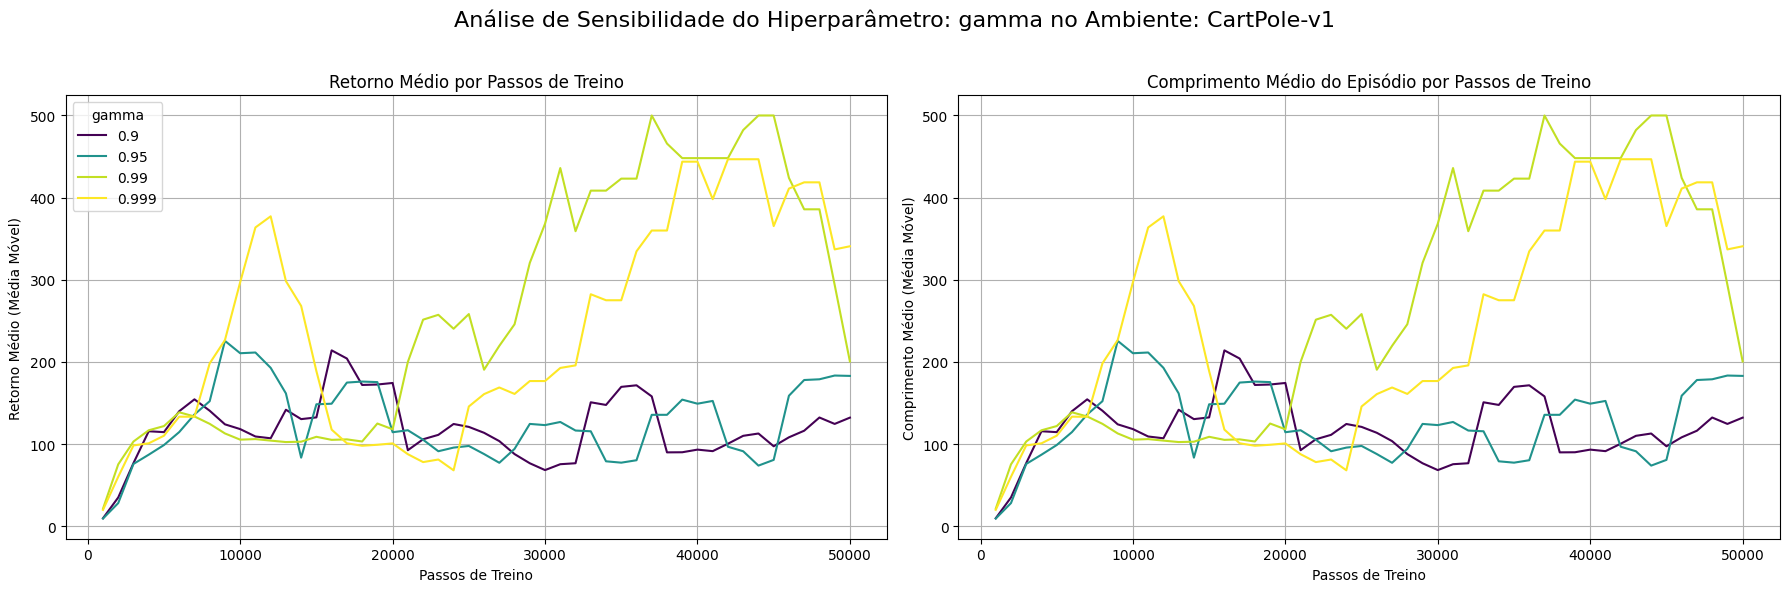

--- Iniciando análise de sensibilidade para 'exploration_fraction' no ambiente 'CartPole-v1' ---


Variando exploration_fraction: 100%|██████████| 4/4 [05:36<00:00, 84.16s/it]



--- Processando resultados e gerando gráficos ---


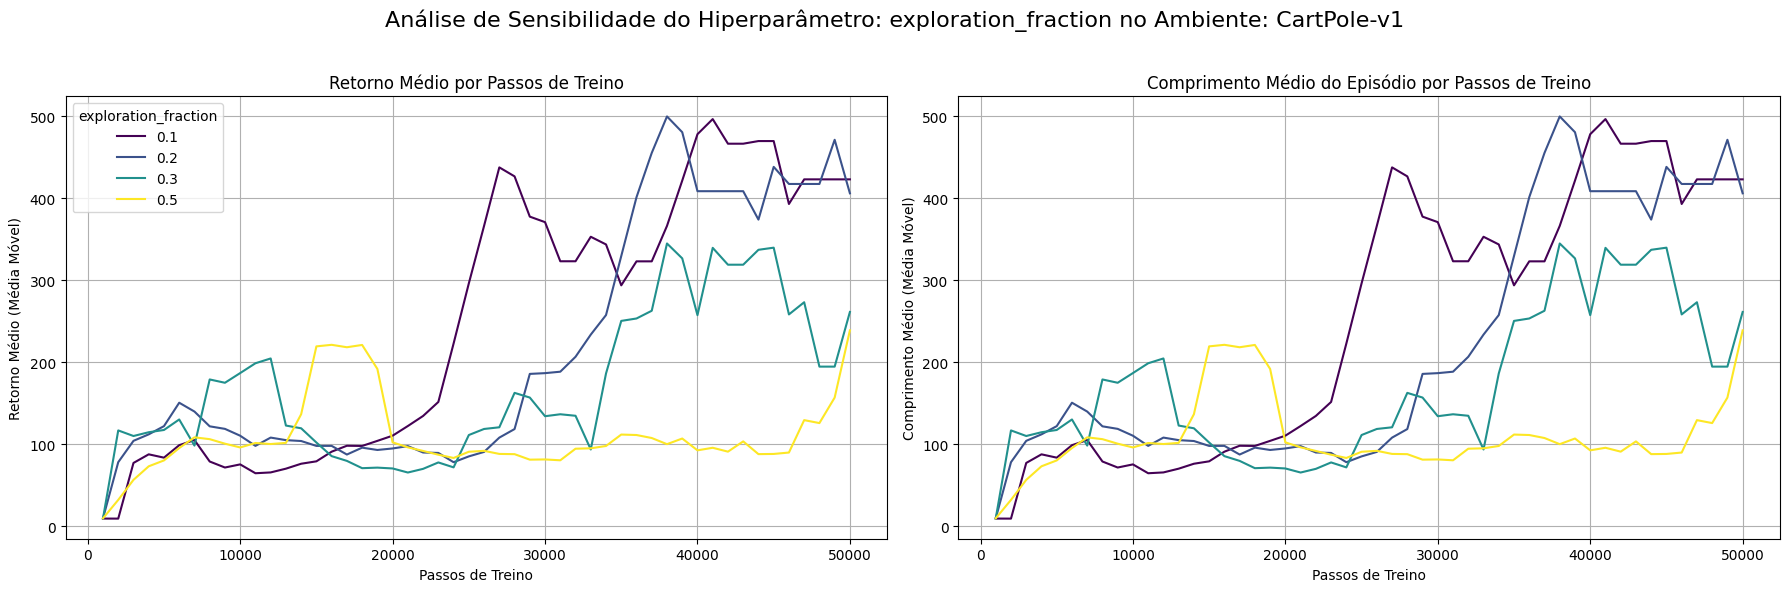

--- Iniciando análise de sensibilidade para 'target_update_interval' no ambiente 'CartPole-v1' ---


Variando target_update_interval: 100%|██████████| 4/4 [06:14<00:00, 93.50s/it] 



--- Processando resultados e gerando gráficos ---


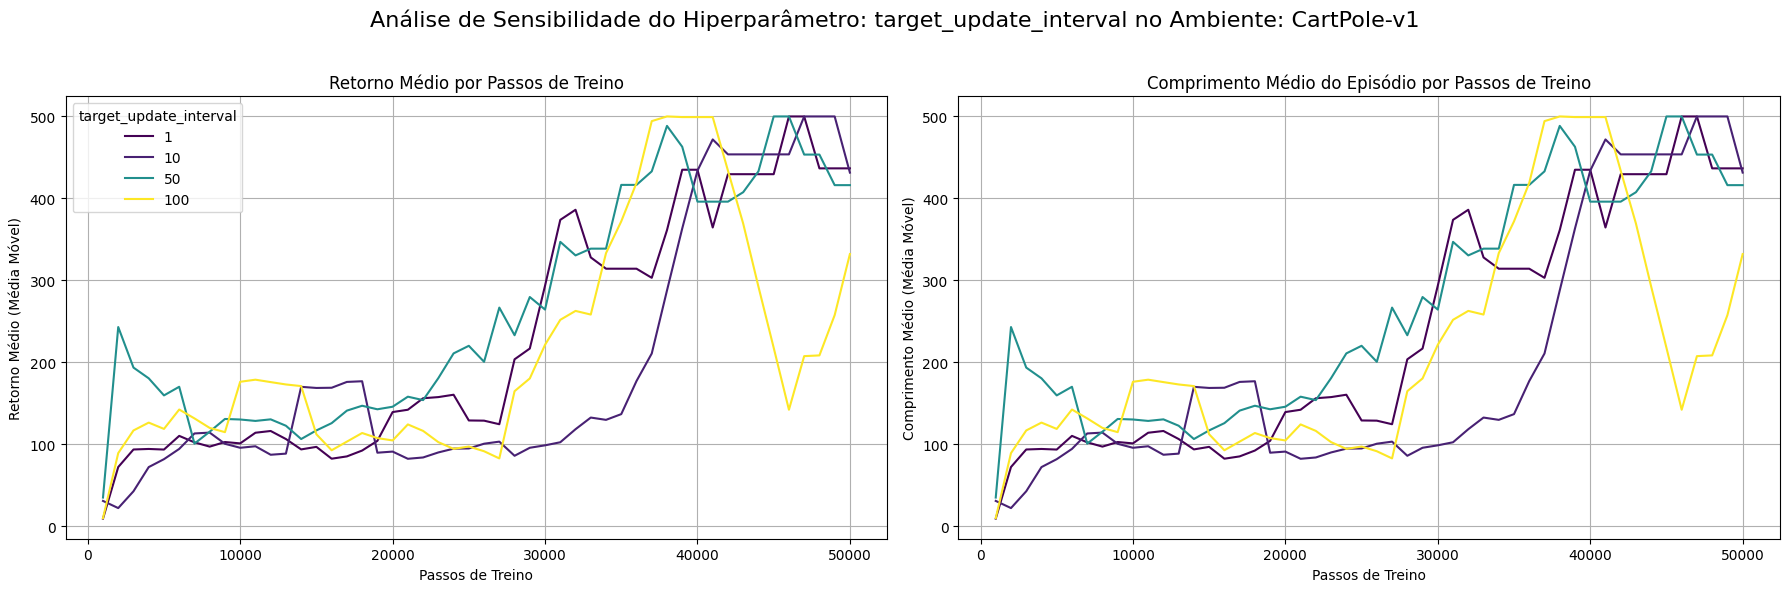

In [79]:
# --- Experimentos para o ambiente CartPole-v1 ---
ambiente_teste = "CartPole-v1"

# Experimento 1: Variando a Taxa de Aprendizado (learning_rate)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="learning_rate",
    param_values=[0.01, 0.001, 0.0001, 0.00001]
)

# Experimento 2: Variando o Fator de Desconto (gamma)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="gamma",
    param_values=[0.9, 0.95, 0.99, 0.999]
)

# Experimento 3: Variando a Fração de Exploração (exploration_fraction)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="exploration_fraction",
    param_values=[0.1, 0.2, 0.3, 0.5]
)

# Experimento 4: Variando o Intervalo de Atualização da Rede Alvo (target_update_interval)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="target_update_interval",
    param_values=[1, 10, 50, 100]
)

--- Iniciando análise de sensibilidade para 'learning_rate' no ambiente 'MountainCar-v0' ---


Variando learning_rate: 100%|██████████| 4/4 [12:09<00:00, 182.32s/it]



--- Processando resultados e gerando gráficos ---


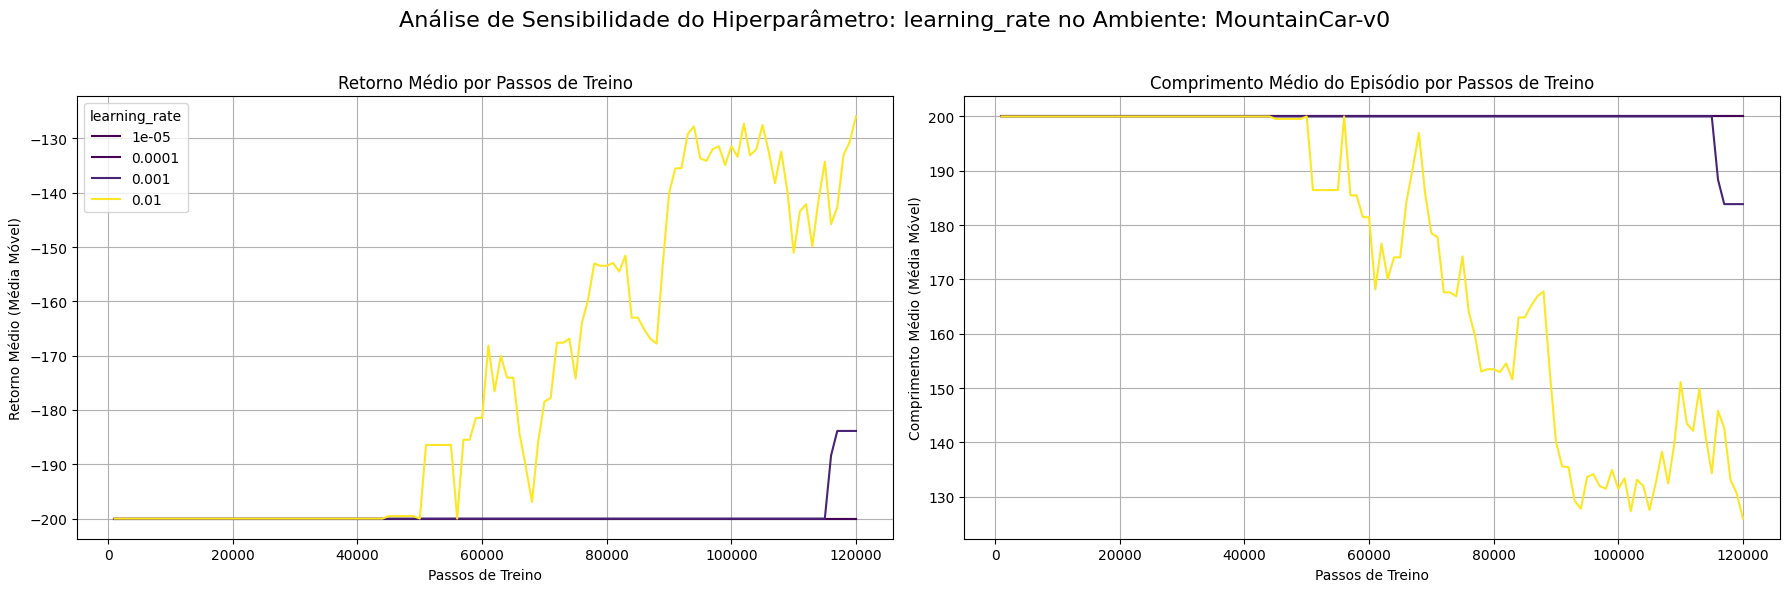

--- Iniciando análise de sensibilidade para 'gamma' no ambiente 'MountainCar-v0' ---


Variando gamma: 100%|██████████| 4/4 [11:48<00:00, 177.17s/it]



--- Processando resultados e gerando gráficos ---


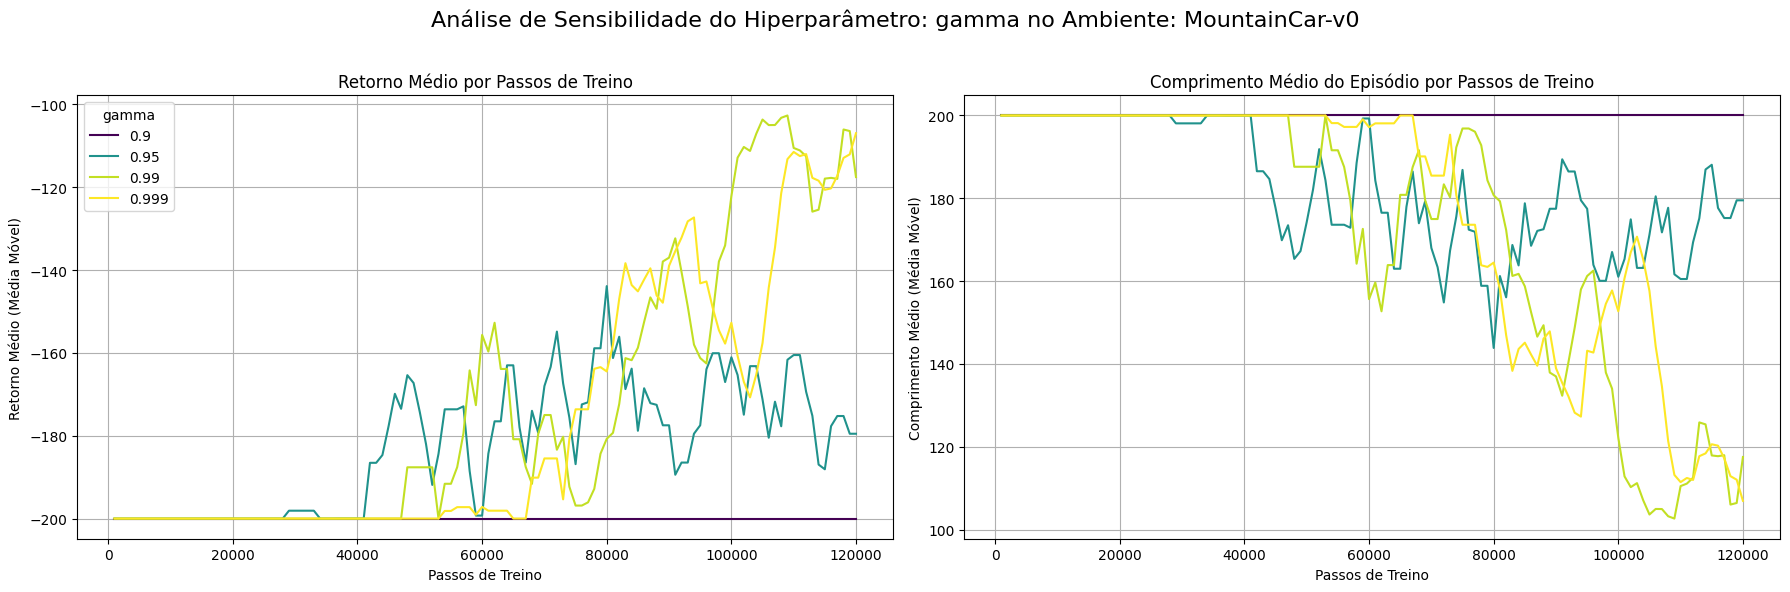

--- Iniciando análise de sensibilidade para 'exploration_fraction' no ambiente 'MountainCar-v0' ---


Variando exploration_fraction: 100%|██████████| 4/4 [11:25<00:00, 171.49s/it]



--- Processando resultados e gerando gráficos ---


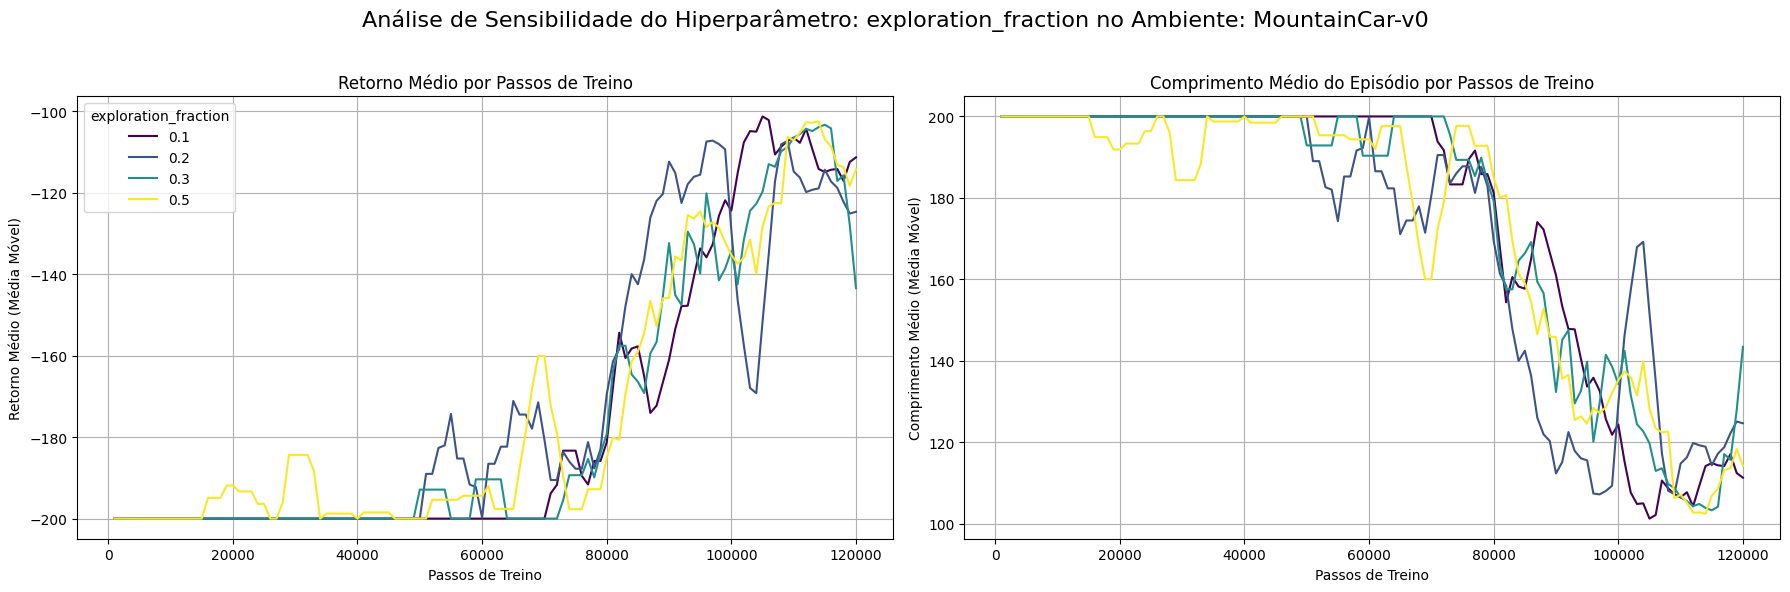

--- Iniciando análise de sensibilidade para 'target_update_interval' no ambiente 'MountainCar-v0' ---


Variando target_update_interval: 100%|██████████| 4/4 [11:49<00:00, 177.41s/it]



--- Processando resultados e gerando gráficos ---


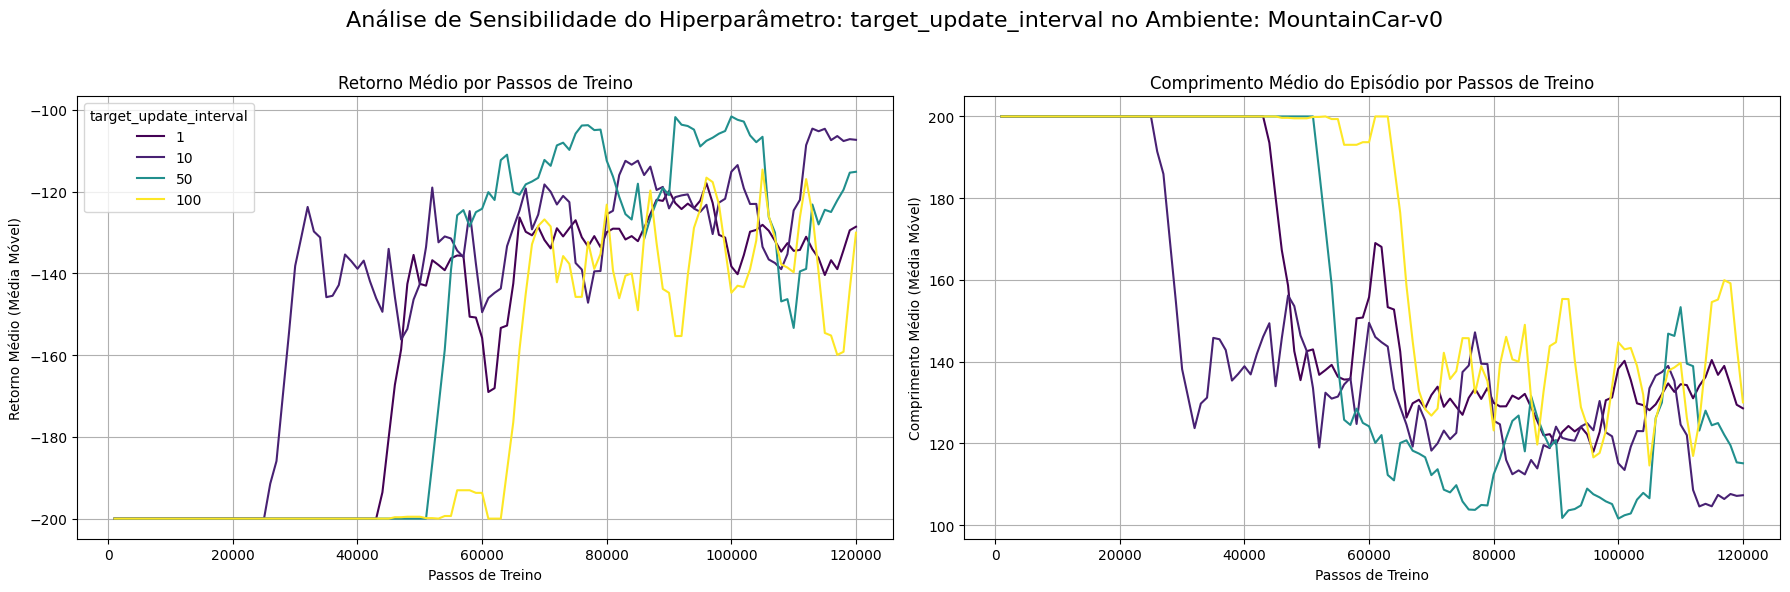

In [80]:
#["MountainCar-v0", "CartPole-v1", "Acrobot-v1"]
ambiente_teste = "MountainCar-v0"

# Experimento 1: Variando a Taxa de Aprendizado (learning_rate)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="learning_rate",
    param_values=[0.01, 0.001, 0.0001, 0.00001]
)

# Experimento 2: Variando o Fator de Desconto (gamma)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="gamma",
    param_values=[0.9, 0.95, 0.99, 0.999]
)

# Experimento 3: Variando a Fração de Exploração (exploration_fraction)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="exploration_fraction",
    param_values=[0.1, 0.2, 0.3, 0.5]
)

# Experimento 4: Variando o Intervalo de Atualização da Rede Alvo (target_update_interval)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="target_update_interval",
    param_values=[1, 10, 50, 100]
)

--- Iniciando análise de sensibilidade para 'learning_rate' no ambiente 'Acrobot-v1' ---


Variando learning_rate: 100%|██████████| 4/4 [16:25<00:00, 246.40s/it]



--- Processando resultados e gerando gráficos ---


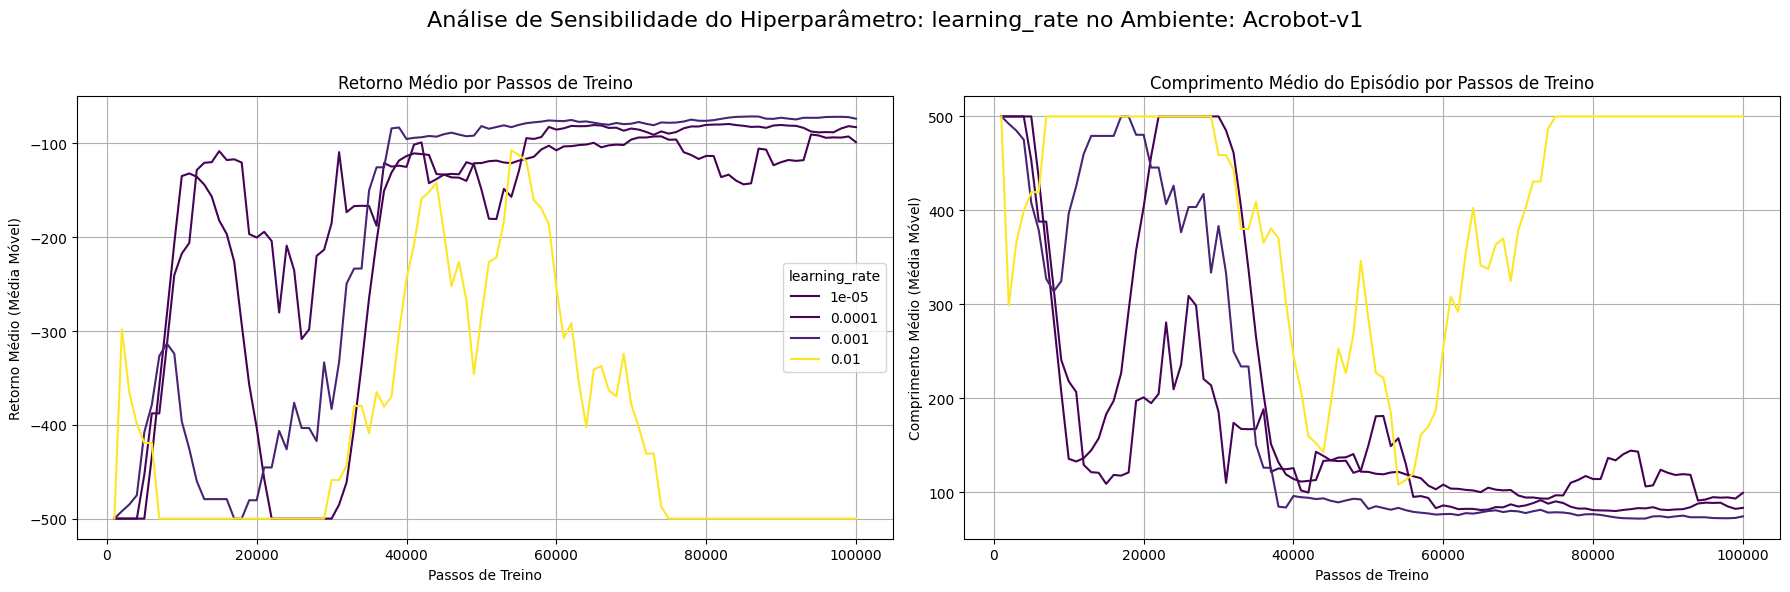

--- Iniciando análise de sensibilidade para 'gamma' no ambiente 'Acrobot-v1' ---


Variando gamma: 100%|██████████| 4/4 [17:51<00:00, 267.87s/it]



--- Processando resultados e gerando gráficos ---


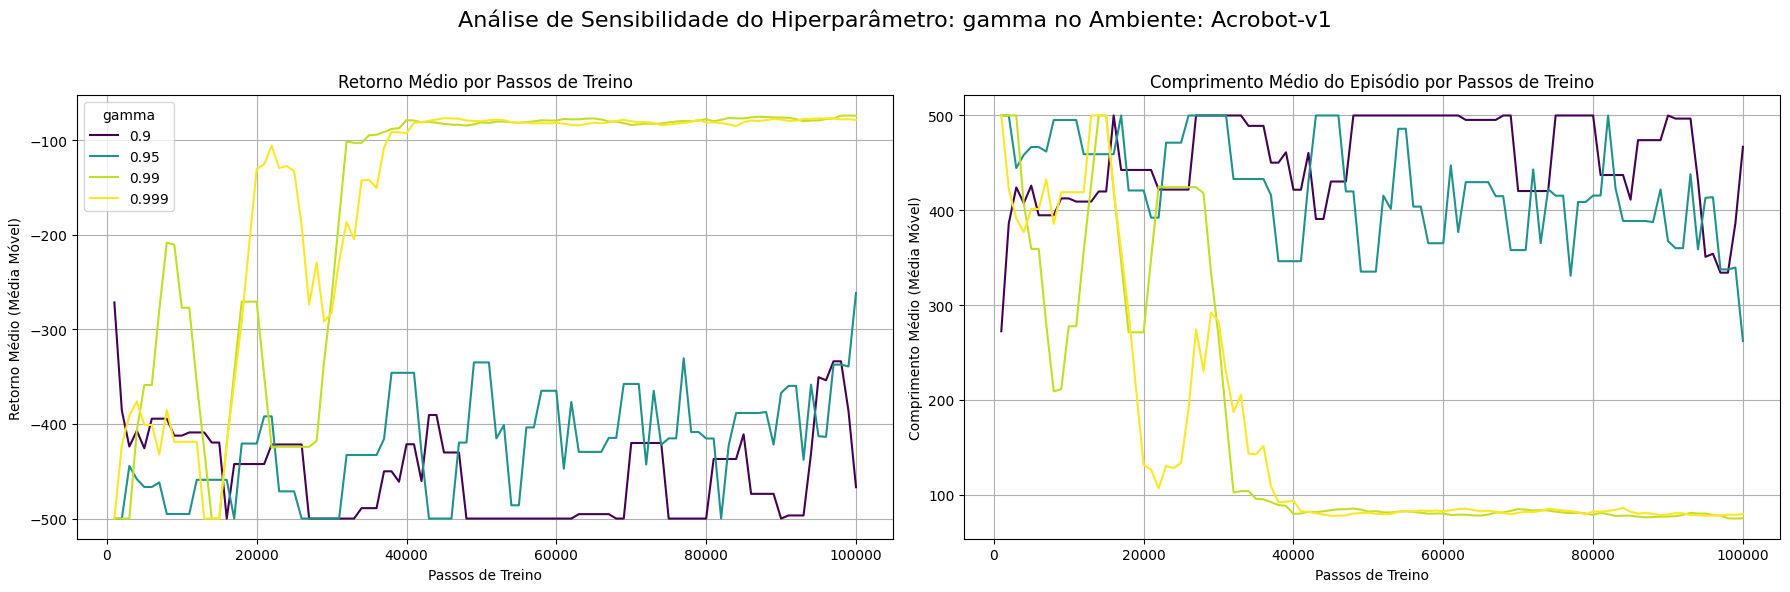

--- Iniciando análise de sensibilidade para 'exploration_fraction' no ambiente 'Acrobot-v1' ---


Variando exploration_fraction: 100%|██████████| 4/4 [14:50<00:00, 222.70s/it]



--- Processando resultados e gerando gráficos ---


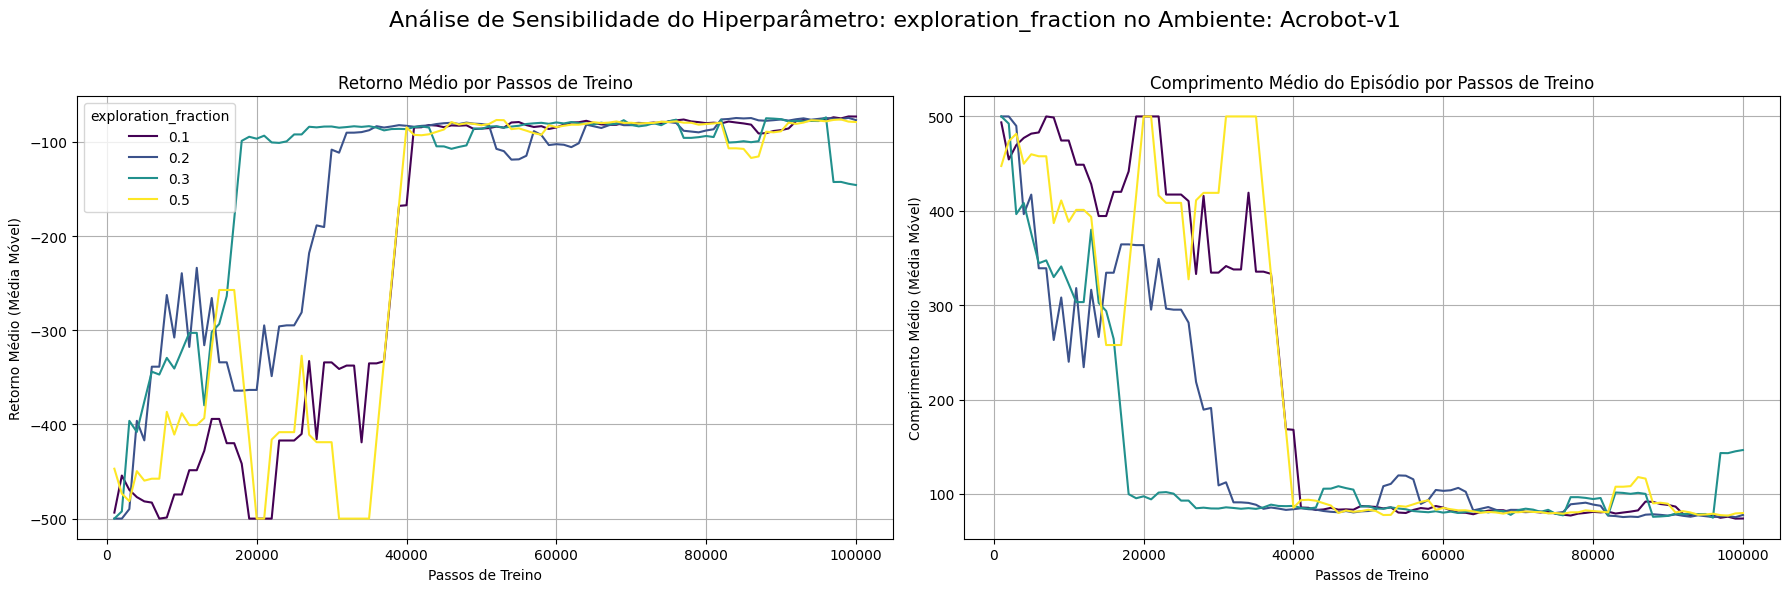

--- Iniciando análise de sensibilidade para 'target_update_interval' no ambiente 'Acrobot-v1' ---


Variando target_update_interval: 100%|██████████| 4/4 [16:33<00:00, 248.35s/it]



--- Processando resultados e gerando gráficos ---


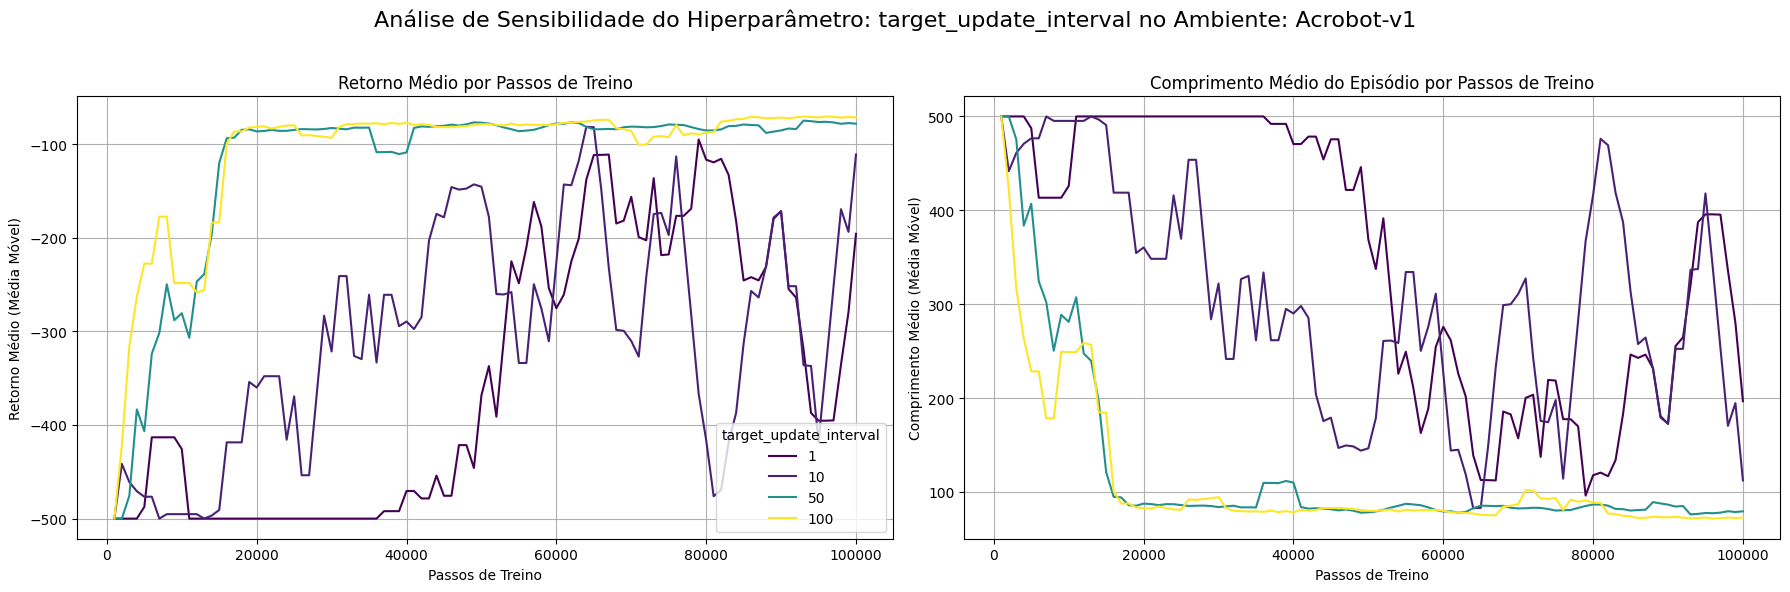

In [81]:
ambiente_teste = "Acrobot-v1"

# Experimento 1: Variando a Taxa de Aprendizado (learning_rate)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="learning_rate",
    param_values=[0.01, 0.001, 0.0001, 0.00001]
)

# Experimento 2: Variando o Fator de Desconto (gamma)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="gamma",
    param_values=[0.9, 0.95, 0.99, 0.999]
)

# Experimento 3: Variando a Fração de Exploração (exploration_fraction)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="exploration_fraction",
    param_values=[0.1, 0.2, 0.3, 0.5]
)

# Experimento 4: Variando o Intervalo de Atualização da Rede Alvo (target_update_interval)
run_sensitivity_analysis(
    env_name=ambiente_teste,
    param_name="target_update_interval",
    param_values=[1, 10, 50, 100]
)

# Tarefa de Experimentos de Sensibilidade a Hiperparâmetros

Para cada um dos três ambientes, formule e execute 4 experimentos distintos em que apenas um hiperparâmetro é variado enquanto todos os outros são mantidos constatntes. Em seguida compare o desempenho (recompensa média e comprimento de episódio) entre as configurações testadas.

Cada um dos 4 experimentos deve:
- Manter todos os outros parâmetros fixos,
- Coletar métricas de recompensa média e comprimento/estabilidade do episódio
- Analisar gráficos comparativos e discorrer sobre como a alteração impactou o aprendizado.

# Experimento CartPole

Experimento 1: Taxa de Aprendizado (learning_rate)

- Impacto no Retorno: Taxas de aprendizado muito altas (ex: 0.01) podem levar a uma convergência instável ou a um desempenho inferior, pois o agente pode "pular" o ótimo. Taxas muito baixas (ex: 0.00001) podem resultar em um aprendizado muito lento, não atingindo o desempenho máximo no tempo estipulado. Um valor intermediário (ex: 0.001) provavelmente mostrará o melhor desempenho, com uma curva de recompensa que sobe rapidamente e se estabiliza em um valor alto.

- Impacto no Comprimento do Episódio: No CartPole, um maior comprimento de episódio é melhor. A análise é análoga à do retorno. Taxas de aprendizado ideais permitirão que o agente equilibre o poste por mais tempo, resultando em episódios mais longos.

Experimento 2: Fator de Desconto (gamma)

- Impacto no Retorno: gamma determina a importância das recompensas futuras. Um gamma baixo (ex: 0.9) torna o agente mais "míope", focando em recompensas imediatas. Um gamma alto (ex: 0.999) o torna mais "paciente". Para o CartPole, onde o objetivo é sobreviver o maior tempo possível, um gamma mais alto geralmente leva a um desempenho melhor, pois incentiva ações que levam a estados futuros mais estáveis.

- Impacto no Comprimento do Episódio: Um gamma maior deve, teoricamente, levar a comprimentos de episódio maiores, pois o agente aprende a valorizar a sobrevivência a longo prazo.

Experimento 3: Fração de Exploração (exploration_fraction)

- Impacto no Retorno: Este parâmetro controla por quanto tempo o agente explora o ambiente com ações aleatórias antes de começar a explorar de forma mais "gananciosa". Uma fração muito pequena pode fazer com que o agente não explore o suficiente e fique preso em uma política subótima. Uma fração muito grande pode fazer com que o agente "perca tempo" explorando aleatoriamente quando já poderia estar refinando uma boa política. Um valor equilibrado é crucial.

- Impacto no Comprimento do Episódio: O comportamento será similar ao do retorno. A exploração adequada permite ao agente descobrir as melhores sequências de ações para se manter equilibrado por mais tempo.

Experimento 4: Intervalo de Atualização da Rede Alvo (target_update_interval)

- Impacto no Retorno: A rede alvo (target network) é usada para estabilizar o aprendizado. Atualizá-la com muita frequência (ex: 1) pode tornar o aprendizado instável, pois o alvo muda a todo momento. Atualizá-la com pouca frequência (ex: 100 ou mais) pode tornar o aprendizado lento, pois o agente estará aprendendo com informações de "valor" desatualizadas. O valor padrão de 10 costuma ser um bom ponto de partida, mas a sensibilidade a ele pode variar.

- Impacto no Comprimento do Episódio: Uma atualização de alvo bem sintonizada resultará em um aprendizado mais estável e, consequentemente, em uma capacidade maior de equilibrar o poste, levando a episódios mais longos.

# Experimento no Mountain-car



Experimento 1: Taxa de Aprendizado (learning_rate)

- Impacto no Retorno: Diferente dos experimentos no cartpole, notamos uma diferença de comportamento no retorno médio por passos de treino, nesse quesito temos um melhor retorno indiscutivelmente no caso do learning_rate = $0.01$ sendo um lr alto no entanto notamos que ao final de $110.000$ passos temos uma resposta para o $lr = 0.001$ 

- Impacto no Comprimento do Episódio: Seguindo a mesma lógica para o impacto de retorno, temos que a partir de $40.000$ passos de treinamento temos uma reatividade para a diminuição do comprimento médio do episódio, fazendo uma aproximação até a raiz do eixo do comprimento médio. No entanto nota-se o mesmo comportamento para o $lr=0.001$ tal que a partir de $110.000$ passos temos um decaimento leve do comprimento médio  

Experimento 2: Fator de Desconto (gamma)

- Impacto no Retorno: Para um desconto gamma sendo uma variação temos um claro parâmetro $gamma = 0.9$ nesse caso temos dois casos de gamma perfeito com $0.999$ e $0.99$ nesse ponto temos uma clara observação de que um gamma mais próximo de $1$ seria o idela para o impacto no retorno e tanto no impacto do comprimento do episódio 

- Impacto no Comprimento do Episódio: Seguindo a mesma lógica do Impacto de Retorno, temos que no comprimento médio do episódio por passos de treino temos as melhores métricas para um gamma próximo a 1 sendo $0.999$ $0.99$ notando uma melhora notável em relação as outras métricas a partir do passo $80.000$

Experimento 3: Fração de Exploração (exploration_fraction)

- Impacto no Retorno: Uma exploration_fraction maior permite ao agente explorar o ambiente por mais tempo antes de começar a seguir sua política aprendida. No início do treinamento, isso pode resultar em retornos mais baixos. No entanto, uma exploração adequada é crucial para o MountainCar, para que o agente descubra a necessidade de construir momento. Um valor bem ajustado levará a um retorno maior e mais estável no final do treinamento.

- Impacto no Comprimento do Episódio: Durante a fase de exploração, o comprimento do episódio tende a ser maior e mais errático. Após essa fase, se o agente aprendeu uma boa política, o comprimento do episódio deve diminuir significativamente. Uma exploration_fraction muito pequena pode fazer com que o agente nunca aprenda a solução e o comprimento do episódio permaneça alto.

Experimento 4: Intervalo de Atualização da Rede Alvo (target_update_interval)

- Impacto no Retorno:  Este parâmetro afeta a estabilidade do aprendizado. Um intervalo de atualização muito frequente (valor baixo) pode tornar o aprendizado instável, causando grandes oscilações no retorno médio. Um intervalo muito longo pode retardar o aprendizado. Um valor intermediário geralmente resulta em um aumento mais estável e consistente do retorno ao longo do tempo.

- Impacto no Comprimento do Episódio: A estabilidade do aprendizado reflete-se aqui. Um target_update_interval bem ajustado levará a uma diminuição mais suave e previsível do comprimento do episódio. Atualizações muito frequentes podem causar picos no gráfico, indicando que o agente "esquece" temporariamente a política aprendida.

# Experimento no Acrobot


Experimento 1: Taxa de Aprendizado (learning_rate)

- Impacto no Retorno: No experimento do acrobot temos uma nótoria observação de que o retorno médio por passos de treino é muito mais estável e com uma convergência mais rápida para o valor máximo, no caso do learning_rate = $0.001$ temos uma convergência mais rápida e um retorno médio maior, enquanto que no caso do learning_rate = $0.01$ temos uma convergência mais lenta e um retorno médio menor.

- No entanto notamos que ao colocar o $lr=0.01$ notamos um decaimento ao passo do aumento dos passos de treinamento sendo talvez um overfitting

- Impacto no Comprimento do Episódio: No comprimento do episódio notamos algumas características trazidas do gráfico anterior porém de forma invertida onde temos uma aproximação com métricas de larning rate menores e um aumento do comprimento do episódio ao colocar um learning rate maior de $0.01$ 

Experimento 2: Fator de Desconto (gamma)

- Impacto no Retorno: No experimento de variação do parâmetro gamma, notamos que valores mais altos de gamma (próximos de 1, como 0.99 e 0.999) proporcionam um retorno médio maior e mais estável ao longo dos passos de treino, indicando que o agente está valorizando melhor as recompensas futuras e aprendendo políticas mais eficazes. Por outro lado, valores mais baixos de gamma (como 0.9) resultam em um retorno médio inferior e uma curva de aprendizado menos consistente, mostrando que o agente tende a priorizar recompensas imediatas e não consegue desenvolver estratégias de longo prazo tão eficientes.

- Impacto no Comprimento do Episódio: No comprimento do episódio, observamos que valores mais altos de gamma também estão associados a episódios mais longos, uma vez que o agente é capaz de planejar melhor suas ações e, assim, alcançar objetivos mais distantes. Em contraste, valores mais baixos de gamma podem levar a episódios mais curtos, já que o agente se concentra em recompensas imediatas e pode não explorar completamente o ambiente.

Experimento 3: Fração de Exploração (exploration_fraction)

- Impacto no Retorno: No comprimento do episódio ao variar o parâmetro exploration_fraction notamos uma convergência de ambos os parâmetros, não tendo grandes variações ou pontos fora da curva, notamos que o mais rápido a convergir é o $exploration_fraction = 0.3$.

- Impacto no Comprimento do Episódio: No comprimento do episódio, observamos que valores mais altos de exploration_fraction estão associados a episódios mais curtos, uma vez que o agente explora mais rapidamente o ambiente e, assim, pode não aproveitar totalmente as recompensas disponíveis. Em contraste, valores mais baixos de exploration_fraction podem levar a episódios mais longos, já que o agente tende a explorar mais o ambiente antes de se fixar em uma política.

Experimento 4: Intervalo de Atualização da Rede Alvo (target_update_interval)

- Impacto no Retorno: No impacto de retorno notamos que ao variar o parâmetro temos uma convergência rápida com as variáveis de $100$ e  $50$ no entando tanto $1$ quanto $10$ apresenta um gráfico mais confuso de interpretação

- Impacto no Comprimento do Episódio: No comprimento do episódio, observamos que valores mais altos de target_update_interval estão associados a episódios mais longos, uma vez que o agente tem mais tempo para explorar o ambiente e aprender com suas experiências. Em contraste, valores mais baixos de target_update_interval podem levar a episódios mais curtos, já que o agente pode não ter tempo suficiente para explorar completamente o ambiente antes de atualizar sua política.